<a href="https://colab.research.google.com/github/kim1987/aiffel/blob/main/aiffel/expoloration/ex_oneone_second.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install cupy

In [2]:
!cp /content/drive/MyDrive/colabdata/aiffel/ex_oneone/data.tar /content/data.tar
!tar xvf data.tar

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
./data/train/PNEUMONIA/person1347_virus_2323.jpeg
./data/train/PNEUMONIA/person1480_bacteria_3858.jpeg
./data/train/PNEUMONIA/person1707_bacteria_4520.jpeg
./data/train/PNEUMONIA/person534_bacteria_2253.jpeg
./data/train/PNEUMONIA/person1857_bacteria_4729.jpeg
./data/train/PNEUMONIA/person937_bacteria_2862.jpeg
./data/train/PNEUMONIA/person1481_bacteria_3862.jpeg
./data/train/PNEUMONIA/person71_bacteria_350.jpeg
./data/train/PNEUMONIA/person549_virus_1089.jpeg
./data/train/PNEUMONIA/person1073_bacteria_3011.jpeg
./data/train/PNEUMONIA/person1042_virus_1737.jpeg
./data/train/PNEUMONIA/person501_bacteria_2115.jpeg
./data/train/PNEUMONIA/person508_bacteria_2144.jpeg
./data/train/PNEUMONIA/person403_bacteria_1814.jpeg
./data/train/PNEUMONIA/person1087_virus_1799.jpeg
./data/train/PNEUMONIA/person702_virus_1299.jpeg
./data/train/PNEUMONIA/person1796_bacteria_4644.jpeg
./data/train/PNEUMONIA/person1482_bacteria_3874.jpeg
./data/train/PNEUMONIA/person1486_b

In [3]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [540, 540]




ROOT_PATH = '/content'
TRAIN_PATH = ROOT_PATH + '/data/train/*/*'
VAL_PATH = ROOT_PATH + '/data/val/*/*'
TEST_PATH = ROOT_PATH + '/data/test/*/*'

In [5]:
BATCH_SIZE = 16
EPOCHS = 20

In [6]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

In [7]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

In [8]:
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

In [11]:

def decode_img(img,resize=True):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    if resize == True:
      img = tf.image.resize(img, IMAGE_SIZE)
    return img

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


In [15]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [16]:
'''
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
'''

'\ndef show_batch(image_batch, label_batch):\n    plt.figure(figsize=(10,10))\n    for n in range(BATCH_SIZE):\n        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)\n        plt.imshow(image_batch[n])\n        if label_batch[n]:\n            plt.title("PNEUMONIA")\n        else:\n            plt.title("NORMAL")\n        plt.axis("off")\n'

In [17]:
'''
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())
'''

'\nimage_batch, label_batch = next(iter(train_ds))\nshow_batch(image_batch.numpy(), label_batch.numpy())\n'

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 10, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 10, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(32, 10, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(256, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [21]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.3
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [23]:
EPOCHS = 8
BATCH_SIZE = 32

In [24]:
with tf.device('/device:GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


In [25]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        #validation_data=val_ds,
        #validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/8
130/130 [==============================] - 120s 615ms/step - loss: 0.4184 - accuracy: 0.7817 - precision: 0.9464 - recall: 0.7467
Epoch 2/8
130/130 [==============================] - 80s 613ms/step - loss: 0.2618 - accuracy: 0.8938 - precision: 0.9691 - recall: 0.8863
Epoch 3/8
130/130 [==============================] - 80s 615ms/step - loss: 0.2478 - accuracy: 0.9062 - precision: 0.9683 - recall: 0.9042
Epoch 4/8
130/130 [==============================] - 80s 616ms/step - loss: 0.1905 - accuracy: 0.9264 - precision: 0.9766 - recall: 0.9228
Epoch 5/8
130/130 [==============================] - 80s 613ms/step - loss: 0.2051 - accuracy: 0.9216 - precision: 0.9678 - recall: 0.9262
Epoch 6/8
130/130 [==============================] - 80s 614ms/step - loss: 0.1837 - accuracy: 0.9279 - precision: 0.9739 - recall: 0.9268
Epoch 7/8
130/130 [==============================] - 80s 613ms/step - loss: 0.1675 - accuracy: 0.9351 - precision: 0.9783 - recall: 0.9334
Epoch 8/8
130/130 [=======

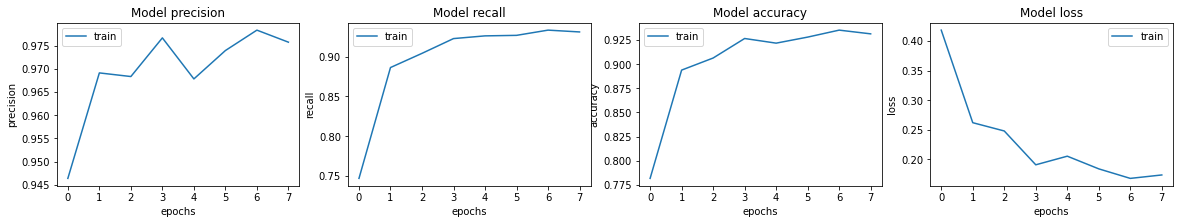

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    #ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    #ax[i].legend(['train', 'val'])
    ax[i].legend(['train'])

In [27]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 540, 540, 32)      9632      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 540, 540, 32)      102432    
_________________________________________________________________
batch_normalization (BatchNo (None, 540, 540, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 270, 270, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 270, 270, 32)      102432    
_________________________________________________________________
batch_normalization_1 (Batch (None, 270, 270, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 135, 135, 32)     

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 11s 252ms/step - loss: 0.5163 - accuracy: 0.7804 - precision: 0.7476 - recall: 0.9795
Loss: 0.516341507434845,
Accuracy: 0.7804487347602844,
Precision: 0.747553825378418,
Recall: 0.9794871807098389


In [29]:

with tf.device('/device:GPU:0'):


    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=4,
        #validation_data=val_ds,
        #validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )


Epoch 1/4
130/130 [==============================] - 94s 614ms/step - loss: 0.1715 - accuracy: 0.9337 - precision: 0.9778 - recall: 0.9325
Epoch 2/4
130/130 [==============================] - 80s 614ms/step - loss: 0.1629 - accuracy: 0.9356 - precision: 0.9762 - recall: 0.9355
Epoch 3/4
130/130 [==============================] - 80s 614ms/step - loss: 0.1505 - accuracy: 0.9428 - precision: 0.9806 - recall: 0.9421
Epoch 4/4
130/130 [==============================] - 80s 616ms/step - loss: 0.1443 - accuracy: 0.9452 - precision: 0.9831 - recall: 0.9423


In [30]:

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')


39/39 [==============================] - 10s 250ms/step - loss: 1.0845 - accuracy: 0.6891 - precision: 0.6678 - recall: 1.0000
Loss: 1.0844873189926147,
Accuracy: 0.6891025900840759,
Precision: 0.6678082346916199,
Recall: 1.0


In [31]:
#model.save('/content/lmsmodel_next')
#!cp /content/lmsmodel_next /content/drive/MyDrive/colabdata/aiffel/ex_oneone/lmsmodel_next

In [32]:
#model.save('/content/lmsmodel_next_days')
#!cp /content/lmsmodel_next_days /content/drive/MyDrive/colabdata/aiffel/ex_oneone/lmsmodel_next_days

In [33]:
#model.save('/content/lmsmodel_nine')
#!mkdir /content/drive/MyDrive/colabdata/aiffel/ex_oneone/lmsmodel_nine
#!cp /content/lmsmodel_nine /content/drive/MyDrive/colabdata/aiffel/ex_oneone/lmsmodel_nine

In [34]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [35]:
with tf.device('/device:GPU:0'):

    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=4,
        #validation_data=val_ds,
        #validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/4
130/130 [==============================] - 94s 617ms/step - loss: 0.1657 - accuracy: 0.9447 - precision: 0.9826 - recall: 0.9427
Epoch 2/4
130/130 [==============================] - 80s 616ms/step - loss: 0.1585 - accuracy: 0.9365 - precision: 0.9815 - recall: 0.9319
Epoch 3/4
130/130 [==============================] - 80s 612ms/step - loss: 0.1411 - accuracy: 0.9433 - precision: 0.9871 - recall: 0.9363
Epoch 4/4
130/130 [==============================] - 80s 614ms/step - loss: 0.1584 - accuracy: 0.9423 - precision: 0.9816 - recall: 0.9393


In [36]:
loss, accuracy, precision, recall = model.evaluate(val_ds,steps=39)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 25s 287ms/step - loss: 0.3945 - accuracy: 0.8478 - precision: 0.9972 - recall: 0.7920
Loss: 0.39451032876968384,
Accuracy: 0.8477563858032227,
Precision: 0.9972144961357117,
Recall: 0.7920354008674622


In [39]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 10s 252ms/step - loss: 0.3274 - accuracy: 0.8814 - precision: 0.9158 - recall: 0.8923
Loss: 0.3274446129798889,
Accuracy: 0.8814102411270142,
Precision: 0.9157894849777222,
Recall: 0.892307698726654


In [ ]:
model.save('/content/lmsmodel_88')
!cp /content/lmsmodel_88 /content/drive/MyDrive/colabdata/aiffel/ex_oneone/lmsmodel_88